
## Netcdf: Interpolation between grids using cKDTree from Scipy library and correlation 




In this post, we will interpolate a nectcdf file to another netcdf grid and then calculate timeseries spearman correlation between two datasets on same resolution grid. 

To interpolate, we will follow this [post](https://www.guillaumedueymes.com/post/netcdf_interpolation/)



In this example, we will interpolate [Daymet-1km dataset](https://daymet.ornl.gov/) on [ERA5-grid](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5).  

We will compute monthly total precipipitation and then compare the two datasets using spearman correlation.  


The Daymet dataset provides gridded estimates of daily weather parameters. Seven surface weather parameters are available at a daily time step, 1 km x 1 km spatial resolution, with a North American spatial extent.

ERA5 Reanalyses provide a numerical description, with horizontal resolution of 31 km, of the recent climate (1979-present) by combining models with observations. 


    
## 1-  Let's import Python librairies   


In [42]:
import warnings; warnings.filterwarnings(action='ignore')
%matplotlib inline
#for Netcdf manipulation
import xarray as xr
from netCDF4 import Dataset
import netCDF4 as nc

#for array manipulation
import numpy as np
import pandas as pd

#for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as plt

#for interpolation
from scipy.spatial import cKDTree

### We will only work over july month from 1980 to 2019: 


##  2 - Interpolation : Daymet-1km to Daymet-32km (ERA5 grid)

We are going to use daily precipitation of Daymet-1km for july. In this analysis, we will use a subset of Daymet-1km and ERA5-32km. Indeed, we will only work over a specific watershed in Canada: Outaouais river's watershed: 

![watershed.png](attachment:image.png)

Here's the script to interpolate: 

In [43]:
path_source = 'K:/PROJETS/PROJET_OUTAOUAIS/Daily/prcp/' # path with daily precipitation
import gc
gc.collect()

variable = 'Prcp'
yi = 1980
yf = 2019

# Load target grid to interpolate
target = xr.open_dataset('Outaouais_ERA5_Grid.nc')
lat_target=target.latitude
lon_target=target.longitude
lat_target.shape

lon_target2d, lat_target2d = np.meshgrid(lon_target, lat_target)

# Load source file to create cKDTree 
source = xr.open_dataset(path_source + 'Daymet_v3_prcp_1980_OUTAOUAIS.nc')
lat_source = source.variables['lat'][:]
lon_source = source.variables['lon'][:]

# function to convert latlon to xy coordinate system
def lon_lat_to_cartesian(lon, lat):
    # WGS 84 reference coordinate system parameters
    A = 6378.137 # major axis [km]   
    E2 = 6.69437999014e-3 # eccentricity squared 
    
    lon_rad = np.radians(lon)
    lat_rad = np.radians(lat)
    # convert to cartesian coordinates
    r_n = A / (np.sqrt(1 - E2 * (np.sin(lat_rad) ** 2)))
    x = r_n * np.cos(lat_rad) * np.cos(lon_rad)
    y = r_n * np.cos(lat_rad) * np.sin(lon_rad)
    z = r_n * (1 - E2) * np.sin(lat_rad)
    return x,y,z

xs, ys, zs = lon_lat_to_cartesian(lon_source.values.flatten(), lat_source.values.flatten())
xt, yt, zt = lon_lat_to_cartesian(lon_target2d.flatten(), lat_target2d.flatten())

tree = cKDTree(np.column_stack((xs, ys, zs)))

d, inds = tree.query(np.column_stack((xt, yt, zt)), k = 10)

# let's define a function to interpolate 
def interpolate(source, target, d, inds):    
    nt = source["time"].shape[0]
    tmp = []
    for t in range(0, nt):        
        w = 1.0 / d**2
        air_idw = np.sum(w * source.prcp[t].values.flatten()[inds], axis=1) / np.sum(w, axis=1)
        air_idw.shape = target.shape
        tmp.append(air_idw)
    return tmp

# we will make a loop over years and save netcdf files by month
for year in range(yi,yf+1):
    source = xr.open_dataset(path_source + 'Daymet_v3_prcp_'+str(year)+'_OUTAOUAIS.nc')
    air_idw = interpolate(source,lon_target2d, d, inds)
    
    data_set = xr.Dataset( coords={'lon': ([ 'lon'], lon_target),
                                     'lat': (['lat',], lat_target),
                                     'time': source.time.values})
    data_set["prcp"] = (['time','lat', 'lon'],  air_idw)
    [data_set.sel(time=str(year)+'-'+'{:02d}'.format(i)).to_netcdf(path_source + 'Daymet_v3_' + variable + '_'+str(year)+'_'+'{:02d}'.format(i)+'_OUTAOUAIS_ERA5grid.nc') for i in range(1,13)]
    


##  3 - Compute monthly indices

We can now open daily files to compute monthly indices. 

In [44]:
yi = 1990
yf = 2019
#########################################################
tmin_in = './Daily/prcp/'
monthly_out = './Month_Indice/' 

# Compute monthly indices
for year in range(yi,yf+1):   # loop over years  
    for i in range(7,8):      # we just want to work over july (i_month = 7)
        data_pcp = tmin_in + 'Daymet_v3_Prcp_' + str(year) +'_{:02d}'.format(i) +'_OUTAOUAIS_ERA5grid.nc'
        ds_pcp = xr.open_mfdataset(data_pcp)         
        monthly_pcp = ds_pcp.sum('time')     # sum over days to calculate monthly accumulation
        # we can save our netcdf files
        monthly_pcp.to_netcdf(monthly_out + 'Daymet_v3_Monthly_PrecTOT_'+str(year) +'{:02d}'.format(i)+'_OUTAOUAIS_ERA5grid.nc',  format='NETCDF4')
            

In [45]:
monthly_pcp

<xarray.Dataset>
Dimensions:  (lat: 29, lon: 121)
Coordinates:
  * lon      (lon) float32 -90.0 -89.75 -89.5 -89.25 ... -60.5 -60.25 -60.0
  * lat      (lat) float32 50.0 49.75 49.5 49.25 49.0 ... 43.75 43.5 43.25 43.0
Data variables:
    prcp     (lat, lon) float64 dask.array<chunksize=(29, 121), meta=np.ndarray>

##  4 - Apply watershed netcdf mask

We will mask a specific area using a netcdf file. To create a netcdf file using any shapefile, please follow this [post](https://www.guillaumedueymes.com/post/shapefile_netcdf/)

In [46]:
# this function will be use later to create a netcdf file using source attributs
def create_file_from_source(src_file, trg_file):
    src = nc.Dataset(src_file)
    trg = nc.Dataset(trg_file, mode='w')

    # Create the dimensions of the file
    for name, dim in src.dimensions.items():
        trg.createDimension(name, len(dim) if not dim.isunlimited() else None)

    # Copy the global attributes
   # trg.setncatts({a:src.getncattr(a) for a in src.ncattrs()})

    # Create the variables in the file
    for name, var in src.variables.items():
        trg.createVariable(name, var.dtype, var.dimensions)

        # Copy the variable attributes
        trg.variables[name].setncatts({a:var.getncattr(a) for a in var.ncattrs()})

        # Copy the variables values (as 'f4' eventually)
        if name not in tomask:
            trg.variables[name][:] = src.variables[name][:]
            
        else:    
            trg.variables[name][:] = data

    # Save the file
    trg.close()

#create 2d grid mask http://meteo.unican.es/work/xarray_seminar/xArray_seminar.html
tomask = ['prcp']

m_f=xr.open_dataset('Outaouais_ERA5_Grid.nc')
lat2d=m_f.variables['latitude'][:]
lon2d=m_f.variables['longitude'][:]
mask = m_f['tp'].values

for year in range(1990,2020):
    for month in range(7,8):
        
        infile = './Month_Indice/Daymet_v3_Monthly_PrecTOT_'+str(year) +'{:02d}'.format(int(month))+'_OUTAOUAIS_ERA5grid.nc'           
        outfile = './Month_Indice/Daymet_v3_Monthly_PrecTOT_'+str(year)+"{:02d}".format(month)+'_OUTAOUAIS_ERA5grid_BV.nc'
       
        nc_Modc=xr.open_dataset(infile)
        nc_Modc.lon.values
        nc_Modf=Dataset(infile,'r')
        data = nc_Modc['prcp'].where(mask >= 0)
        create_file_from_source(infile, outfile)


##  5 - Compute correlation

To compute spearman correlation, we use stats module from [scipy library](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.stats.mstats.spearmanr.html/)


In [49]:
from scipy import stats
import numpy as np

variable = 'Monthly_PrecTOT'
yi = 1990
yf = 2020
out = './Month_Indice/'
for month in ['07']:  
    # load ERA5 
    path_era5 = 'J:/REANALYSES/ERA5/Month_PrecTOT_Outaouais/'
    file = path_era5 + 'ERA5_Outaouais_Monthly_PrecTOT_CAN_'
    multi_file = [f'{file}{year}{month}_BV.nc' for year in range(yi,yf,1)]
    era5_all = xr.concat([xr.open_dataset(f) for f in multi_file], 'day')
    
    # load daymet
    path_daymet = 'K:/PROJETS/PROJET_OUTAOUAIS/Month_Indice/'
    
    file = path_daymet + 'Daymet_v3_'+variable + '_'
    multi_file = [f'{file}{year}{month}_OUTAOUAIS_ERA5grid_BV.nc' for year in range(yi,yf,1)]
    daymet_all = xr.concat([xr.open_dataset(f) for f in multi_file], 'time')
    
    # Spearman correlation between two datasets for each grid point
    corr_spearman_ERA5 = np.zeros((era5_all['tp'].shape[1],era5_all['tp'].shape[2]),dtype=float)    
    for ni in range(0,era5_all['tp'].shape[2]):   # loop over longitudes
        for nj in range(0, era5_all['tp'].shape[1]):  # loop over latitudes
            
             r, p = stats.spearmanr(era5_all.isel(latitude=[nj], longitude=[ni]).tp.values[:,0,0] ,
                                   daymet_all.isel(lat=[nj], lon=[ni]).prcp.values[:,0,0] ) 
             if p >= 0.1 :
                 corr_spearman_ERA5[nj,ni] = np.nan
             else:
                 corr_spearman_ERA5[nj,ni] = r
                 
    data_set = xr.Dataset( coords={'lon': ([ 'lon'], era5_all.longitude),
                                             'lat': (['lat',], era5_all.latitude)})
    
    data_set["spearmanr"] = (['lat', 'lon'],  corr_spearman_ERA5)
        
    data_set.to_netcdf(out + 'Daymet_v3_spearmann_Correlation_ERA5grid' + variable + '_'+str(yi)+'_'+str(yf)+'_'+month+'_OUTAOUAIS_python.nc')             
             

##  6 - Plot correlation 

We can now make a quick plot using matplotlib. 

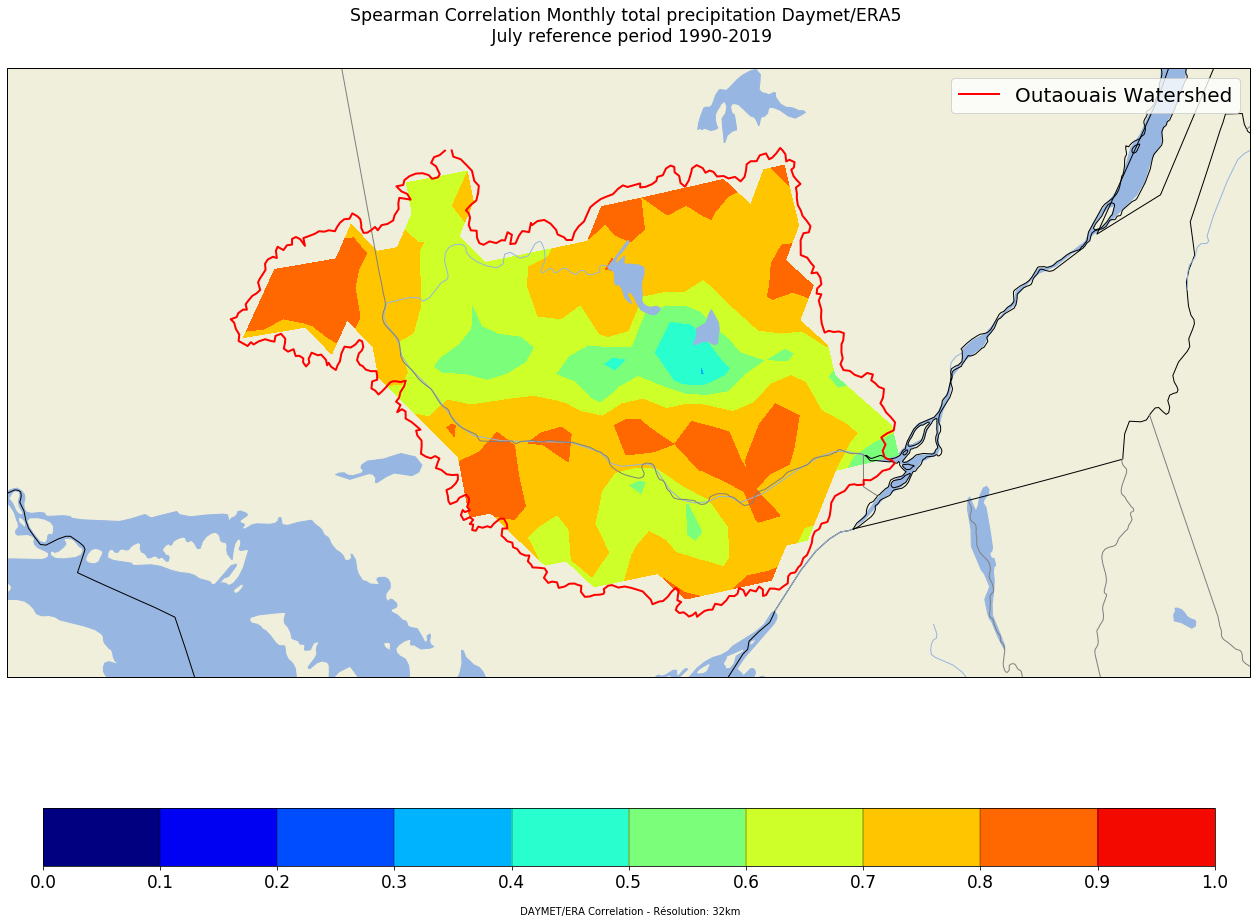

In [50]:
from netCDF4 import Dataset
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib as mpl
import pandas as pd
import datetime
####https://uoftcoders.github.io/studyGroup/lessons/python/cartography/lesson/

## Date à utiliser 

path_in='./Month_Indice/'
file = 'Daymet_v3_spearmann_Correlation_ERA5gridMonthly_PrecTOT'
yi = 1990
yf = 2020
# lecture du contour du bassin versant 
BV_border = pd.read_csv('./points_contour_BV.csv', sep=',')
def plot_background(ax):
    ax.set_extent([-84,-70,45,48])
    ax.coastlines(resolution='110m');
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))      
    ax.add_feature(cfeature.LAND.with_scale('50m'))       
    ax.add_feature(cfeature.LAKES.with_scale('50m'))     
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))    
    ax.add_feature(cfeature.RIVERS.with_scale('50m'))    
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',    
                        facecolor='none', name='coastline')
    ax.add_feature(coast, edgecolor='black')
    
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax.add_feature(states_provinces, edgecolor='gray')

   
    return ax

for month in ['07']:
        
    monthstr = datetime.date(1900, int(month), 1).strftime('%B')   
    filename = path_in + file
    
    dset=Dataset(filename + '_' + str(yi) + '_' + str(yf) + '_' + month +'_OUTAOUAIS_python.nc')
    ## Lecture du fichier 
    var=dset.variables['spearmanr'][:].squeeze()
    lon=dset.variables['lon'][:]
    lat=dset.variables['lat'][:]

    
    fig = plt.figure(figsize=(28,16))
    crs=ccrs.LambertConformal()
    ax = plt.axes(projection=crs)
    plot_background(ax)
    
    ## Choisissons une colormap
    cmap0 = mpl.cm.get_cmap('jet', 11)
    #cmap0.set_under('w') ## on met en blanc les valeurs inferieures au min de clev
    #cmap0.set_over('black')
    levels = np.arange(0,1.1,0.1) 
    mm = ax.contourf(lon,\
                           lat,\
                           var,\
                           vmin=0.,\
                           vmax=1.1, \
                           transform=ccrs.PlateCarree(),\
                           cmap=cmap0,
                           levels=levels)
        
    # ajout du contour du basson versant 
    colors = ['red']
    maskBV = ['Outaouais Watershed']                      
    ax.plot(BV_border.X,BV_border.Y, transform=ccrs.PlateCarree(), color=colors[0], linewidth=2, label=maskBV[0])
    plt.legend(loc="best", markerscale=2., fontsize=20)
    xticks = np.arange(-150.0,-40.0,20)
    yticks =np.arange(10,80,10)    
    fig.canvas.draw()    

    cbar = plt.colorbar(mm, orientation='horizontal', shrink=0.75, drawedges='True', ticks=np.arange(0., 1.1, .1),extend='both')
    cbar.set_label(u'\n DAYMET/ERA Correlation - Résolution: 32km', size='medium') # Affichage de la légende de la barre de couleur
    cbar.ax.tick_params(labelsize=17)  
    
    string_title=u'Spearman Correlation Monthly total precipitation Daymet/ERA5 \n ' + monthstr + ' reference period 1990-2019\n'
    plt.title(string_title, size='xx-large')
    plt.savefig(path_in + 'Spearman_DAYMET_ERA5_PrecTOT_1990-2019_'+str(month)+'_python.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()  
    plt.close()